In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import scipy.stats as stats
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.datasets import make_blobs
from sklearn import preprocessing 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import pmdarima as pm

# read data

df = pd.read_csv('teleco_time_series.csv', index_col = 'Day', parse_dates = True)

# shape and data types of the data
print(df.shape)
print(df.dtypes)

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)


C:\Users\mjackson\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(731, 1)
Revenue    float64
dtype: object
['Revenue']
[]


In [2]:
type(df)

pandas.core.frame.DataFrame

In [3]:
df.columns

Index(['Revenue'], dtype='object')

In [4]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [5]:
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [6]:
# find percentage of data that is missing 

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Revenue - 0%


In [7]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [8]:
df.dropna(how='all')

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554
...,...
727,16.931559
728,17.490666
729,16.803638


In [9]:
df['Date'] = (pd.date_range(start=datetime.datetime(2019, 1, 1),
                           periods=df.shape[0], freq='24H'))
df.set_index('Date', inplace = True)
df

,Revenue
Date,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554
...,...
2020-12-27,16.931559
2020-12-28,17.490666
2020-12-29,16.803638


In [10]:
df.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=731, freq=None)

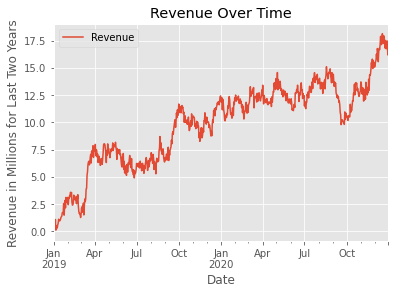

In [11]:
# Plot the time series
df.plot()
plt.title("Revenue Over Time")
plt.ylabel("Revenue in Millions for Last Two Years")
plt.show();

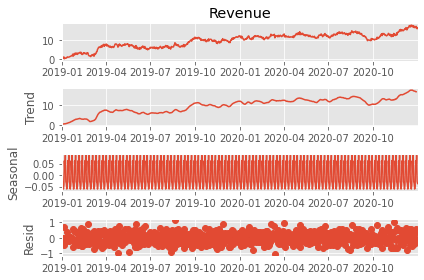

In [12]:
decomp = seasonal_decompose(df['Revenue'])
decomp.plot()
plt.show()

In [13]:
result = adfuller(df['Revenue'])
print('Test stats:', result[0])
print('P-value:', result[1])
print('Critical values:', result[4])

# H0: Time Series is non-stationary
# H1: Time Series is stationary

if result[1]<=0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Failure to reject null hypothesis, the time series is non-stationary")

Test stats: -1.9246121573101804
P-value: 0.320572815079398
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Failure to reject null hypothesis, the time series is non-stationary


In [14]:
#Find the proper 80/20 split

proper_split = round(len(df)* 0.80)
print(proper_split, "rows")
proper_split_date = df.iloc[[585]].index.values
print(proper_split_date)

585 rows
['2020-08-08T00:00:00.000000000']


In [15]:
X_train = df.loc[:'2020-08-07']
X_test = df.loc['2020-08-08':]

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train Shape (585, 1)
X_test Shape (146, 1)


In [16]:
pd.DataFrame(X_train).to_csv("X_train.csv")
pd.DataFrame(X_test).to_csv("X_test.csv")

In [17]:
df_diff = df.diff().dropna()

In [18]:
result = adfuller(df_diff['Revenue'])
print('Test stats:', result[0])
print('P-value:', result[1])
print('Critical values:', result[4])

# H0: Time Series is non-stationary
# H1: Time Series is stationary

if result[1]<=0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Failure to reject null hypothesis, the time series is non-stationary")

Test stats: -44.874527193876
P-value: 0.0
Critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


In [19]:
df_diff.head()

,Revenue
Date,
2019-01-02,0.000793
2019-01-03,0.824749
2019-01-04,-0.505210
2019-01-05,0.762222
2019-01-06,-0.974900


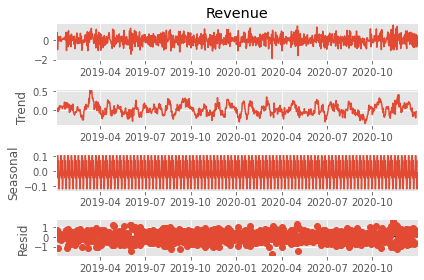

In [20]:
decomp = seasonal_decompose(df_diff['Revenue'])
decomp.plot()
plt.show()

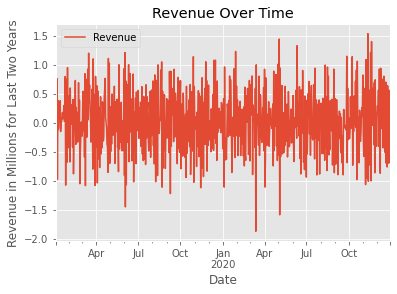

In [21]:
# Plot the time series
df_diff.plot()
plt.title("Revenue Over Time")
plt.ylabel("Revenue in Millions for Last Two Years")
plt.show();

<AxesSubplot:xlabel='Date'>

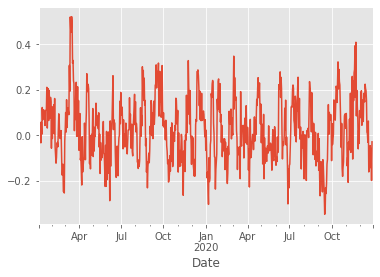

In [22]:
decomp.trend.plot()

<AxesSubplot:xlabel='Date'>

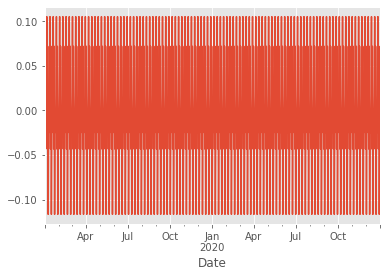

In [23]:
decomp.seasonal.plot()

<AxesSubplot:xlabel='Date'>

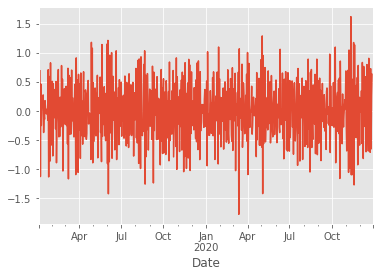

In [24]:
decomp.resid.plot()

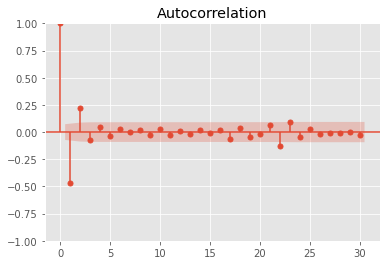

In [25]:
plot_acf(df_diff, lags=30)
plt.show()

C:\Users\mjackson\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


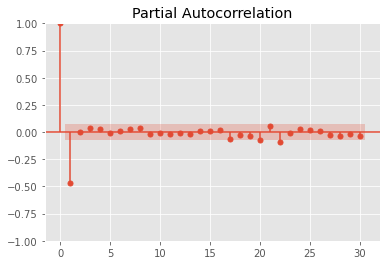

In [26]:
plot_pacf(df_diff, lags=30)
plt.show()

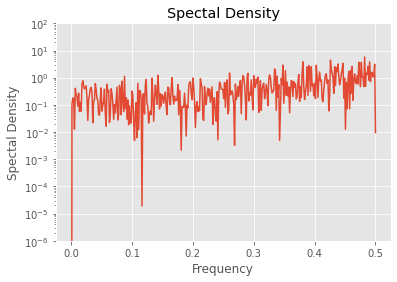

In [27]:
f, Pxx_den = signal.periodogram(df_diff['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectal Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()


In [28]:
model_best = pm.auto_arima(X_train['Revenue'],
                     trace=True,
                     suppress_warnings=True,
                     max_p=30, max_q=30, max_order=30,
                     stepwise=True,
                     seasonal=False)
print(model_best.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=777.983, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=910.790, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=773.893, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=799.464, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=909.948, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=775.886, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=775.888, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=777.694, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=774.990, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.811 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -383.946
Date:                Wed, 28 Sep 2022   AIC               

In [29]:
model = SARIMAX(X_train['Revenue'], order=(1,1,0), trend = 'c')
results = model.fit()

mae = np.mean(np.abs(results.resid))

print("The mean absolute error is:", round(mae,2))

The mean absolute error is: 0.38


C:\Users\mjackson\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mjackson\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


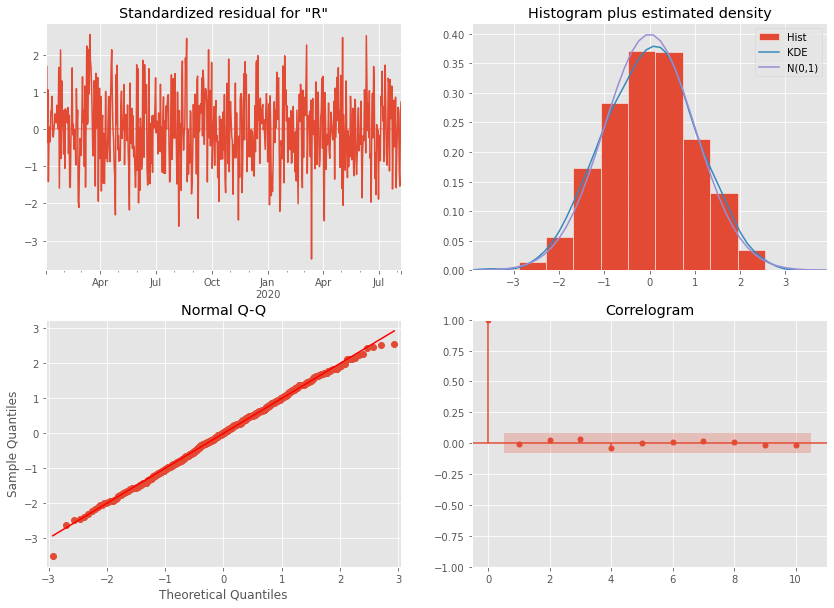

In [30]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

<AxesSubplot:xlabel='Date'>

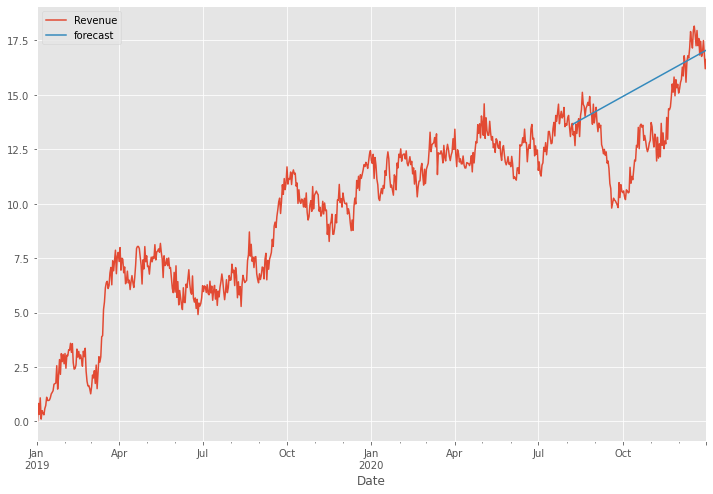

In [31]:
df['forecast']=results.predict(start=585,end=731,dynamic=True)
df[['Revenue','forecast']].plot(figsize=(12,8))

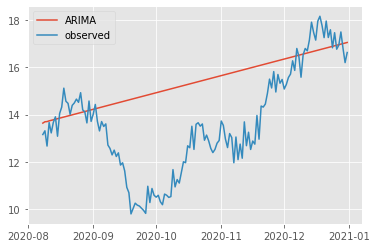

In [32]:
# Create ARIMA mean forecast prediction
arima_test = results.get_forecast(steps=146)
arima_mean = arima_test.predicted_mean

# Plot mean ARIMA predictions and observed for test data
plt.plot(X_test.index, arima_mean, label='ARIMA')
plt.plot(X_test, label='observed')
plt.legend()
plt.show()

In [33]:
diff_forecast = results.get_forecast(steps=180)
mean_forecast = diff_forecast.predicted_mean
confidence_intervals = diff_forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']


In [34]:
#Generate predictions
prediction = results.get_prediction(start=-90)
#Extract prediction mean
mean_prediction = prediction.predicted_mean
#Get confidence intervals of predictions
confidence_intervals = prediction.conf_int()
#Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower Revenue']
upper_limits = confidence_intervals.loc[:, 'upper Revenue']
print(mean_forecast)

2020-08-08    13.636207
2020-08-09    13.692649
2020-08-10    13.700798
2020-08-11    13.731146
2020-08-12    13.751290
                ...    
2021-01-30    17.746391
2021-01-31    17.769748
2021-02-01    17.793105
2021-02-02    17.816462
2021-02-03    17.839820
Freq: D, Name: predicted_mean, Length: 180, dtype: float64


InvalidIndexError: (slice(None, None, None), None)

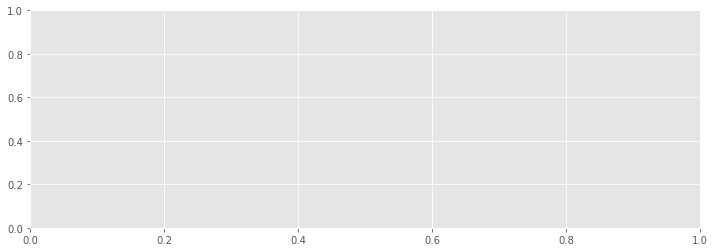

In [35]:
#plot the data
plt.figure(figsize=(12,4))
plt.plot(X_test.index, X_test, label = 'Observed (Test Set)')
#Plot your mean predictions
plt.plot(mean_prediction.index, mean_prediction, color='r', label='forecast')
#shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
#set labels, legends and show plot
plt.title('Forecast comparing with test data')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.legend()
plt.show()

In [36]:
#ignore below this ----------------------

In [38]:
prediction = pd.DataFrame(model_best.predict(n_periods = 365),index=X_test.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
Date,
2020-08-08,13.636207
2020-08-09,13.692649
2020-08-10,13.700798
2020-08-11,13.731146
2020-08-12,13.751290
...,...
2020-12-27,16.952244
2020-12-28,16.975602
2020-12-29,16.998959
